# Lab 7.3 — SHAP Values (Explainable AI for Digital Health)

In this lab, you will train a simple **heart disease risk** classifier and use **SHAP** to explain:
- **Global** behavior (which features matter most overall)
- **Local** behavior (why a specific case gets a high/low risk prediction)

Dataset: `heart_disease_uci.csv`

Kaggle URI: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data?resource=download

Context:

This is a multivariate type of dataset which means providing or involving a variety of separate mathematical or statistical variables, multivariate numerical data analysis. It is composed of 14 attributes which are age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, oldpeak — ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment, number of major vessels and Thalassemia. This database includes 76 attributes, but all published studies relate to the use of a subset of 14 of them. The Cleveland database is the only one used by ML researchers to date. One of the major tasks on this dataset is to predict based on the given attributes of a patient that whether that particular person has heart disease or not and other is the experimental task to diagnose and find out various insights from this dataset which could help in understanding the problem more.

Column Descriptions:

id (Unique id for each patient)

age (Age of the patient in years)

origin (place of study)

sex (Male/Female)

cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])

trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))

chol (serum cholesterol in mg/dl)

fbs (if fasting blood sugar > 120 mg/dl)

restecg (resting electrocardiographic results)

-- Values: [normal, stt abnormality, lv hypertrophy]

thalach: maximum heart rate achieved

exang: exercise-induced angina (True/ False)

oldpeak: ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

ca: number of major vessels (0-3) colored by fluoroscopy

thal: [normal; fixed defect; reversible defect]

num: the predicted attribute

## Learning objectives
By the end of this lab, you should be able to:
1. Load and preprocess a clinical dataset (mixed numeric + categorical)
2. Train and evaluate a baseline classification model
3. Use **SHAP** to explain predictions:
   - Global: *summary plot*, *feature importance bar plot*
   - Local: *waterfall plot* for individual cases
4. Communicate model explanations in plain language (not causality)


In [1]:
# If you run this in Google Colab, install dependencies first
!pip -q install shap scikit-learn pandas matplotlib


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
)

from sklearn.ensemble import RandomForestClassifier

import shap


/opt/miniconda3/envs/dsde/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Load data

If you are using **Colab**, upload `heart_disease_uci.csv` to `/content/`.


In [ ]:
import os

def resolve_data_path(filename: str) -> str:
    candidates = [
        filename,
        os.path.join(".", filename),
        os.path.join("/content", filename),  # Colab default
    ]
    for p in candidates:
        if os.path.exists(p):
            return p

    # If not found, download from GitHub (Colab-friendly)
    raw_url = "https://raw.githubusercontent.com/pvateekul/digitalhealth-ai2025/main/code/Class07_ASR%26FaceRecognition/heart_disease_uci.csv"
    print(f"{filename} not found. Downloading from GitHub...")
    os.system(f'wget -q -O "{filename}" "{raw_url}"')

    # Check again after download
    for p in candidates:
        if os.path.exists(p):
            print(f"Downloaded to: {os.path.abspath(p)}")
            return p

    raise FileNotFoundError(
        f"Could not find or download {filename}. Please check internet access or the URL."
    )

data_path = resolve_data_path("heart_disease_uci.csv")
print("Using:", data_path)

df = pd.read_csv(data_path)

print("Loaded:", data_path)
print("Shape:", df.shape)
df.head()


Using: heart_disease_uci.csv
Loaded: heart_disease_uci.csv
Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## 2) Define the prediction target

In this dataset, `num` is commonly used as **disease severity**:
- `num = 0` means *no heart disease*
- `num > 0` means *heart disease present*

For this lab, we create a **binary** target:  
`target = 1 if num > 0 else 0`


In [4]:
# Basic checks
print(df["num"].value_counts(dropna=False).sort_index())

# Binary target
df["target"] = (df["num"] > 0).astype(int)

print("\nBinary target distribution:")
print(df["target"].value_counts(normalize=True).rename("proportion"))


num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Binary target distribution:
target
1    0.553261
0    0.446739
Name: proportion, dtype: float64


## 3) Prepare features (X) and labels (y)

We drop:
- `id` (identifier)
- `num` (original multi-class / severity label)

Everything else becomes an input feature.


In [5]:
df.isna().sum()
zero_as_missing = ["chol", "trestbps", "thalch"]
for c in zero_as_missing:
    if c in df.columns:
        df[c] = df[c].replace(0, np.nan)

In [6]:
drop_cols = ["id", "num"]
        
X = df.drop(columns=drop_cols + ["target"], errors="ignore")
y = df["target"].astype(int)

# Identify feature types
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Numeric columns:", num_cols)
print("Categorical/boolean columns:", cat_cols)

Numeric columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical/boolean columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


## 4) Train/test split


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=2026,
    stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (690, 14)  Test: (230, 14)


## 5) Build a baseline model (preprocessing + classifier)

We will use:
- **Imputation** (fill missing values)
- **One-hot encoding** for categorical features
- **RandomForestClassifier** as a strong, simple baseline


In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

model = RandomForestClassifier(
    n_estimators=400,
    random_state=2026,
    class_weight="balanced",
    n_jobs=-1,
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

clf


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

## 6) Train + evaluate


In [9]:
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC : {auc:.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
confusion_matrix(y_test, y_pred)


Accuracy: 0.852
ROC-AUC : 0.934

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       103
           1       0.84      0.91      0.87       127

    accuracy                           0.85       230
   macro avg       0.86      0.85      0.85       230
weighted avg       0.85      0.85      0.85       230

Confusion matrix:


array([[ 81,  22],
       [ 12, 115]])

## 7) SHAP explanations

### Important concept
SHAP explains **the model's behavior** (how it uses inputs), not medical causality.

Because our model uses one-hot encoding, we compute SHAP on the **transformed feature matrix**.


In [10]:
# Transform data into the model's feature space (preprocessed)
X_train_t = clf.named_steps["preprocess"].transform(X_train)
X_test_t  = clf.named_steps["preprocess"].transform(X_test)
print(X_train_t[0])
ohe = clf.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + cat_feature_names
print(feature_names)

len(feature_names), X_test_t.shape

[ 32. 125. 254. 155.   0.   0.   0.   1.   0.   1.   0.   0.   0.   1.
   0.   0.   1.   0.   0.   1.   0.   1.   0.   0.   1.   0.   0.   1.
   0.]
['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'sex_Female', 'sex_Male', 'dataset_Cleveland', 'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_False', 'fbs_True', 'restecg_lv hypertrophy', 'restecg_normal', 'restecg_st-t abnormality', 'exang_False', 'exang_True', 'slope_downsloping', 'slope_flat', 'slope_upsloping', 'thal_fixed defect', 'thal_normal', 'thal_reversable defect']


(29, (230, 29))

### 7.1 Global explanation — SHAP summary plot
- Shows which features matter most overall
- Color indicates feature value (low → high)


(230, 29, 2)
[[ 0.02813492 -0.02813492]
 [-0.01099459  0.01099459]
 [ 0.01508982 -0.01508982]
 [ 0.10581561 -0.10581561]
 [ 0.04896987 -0.04896987]]


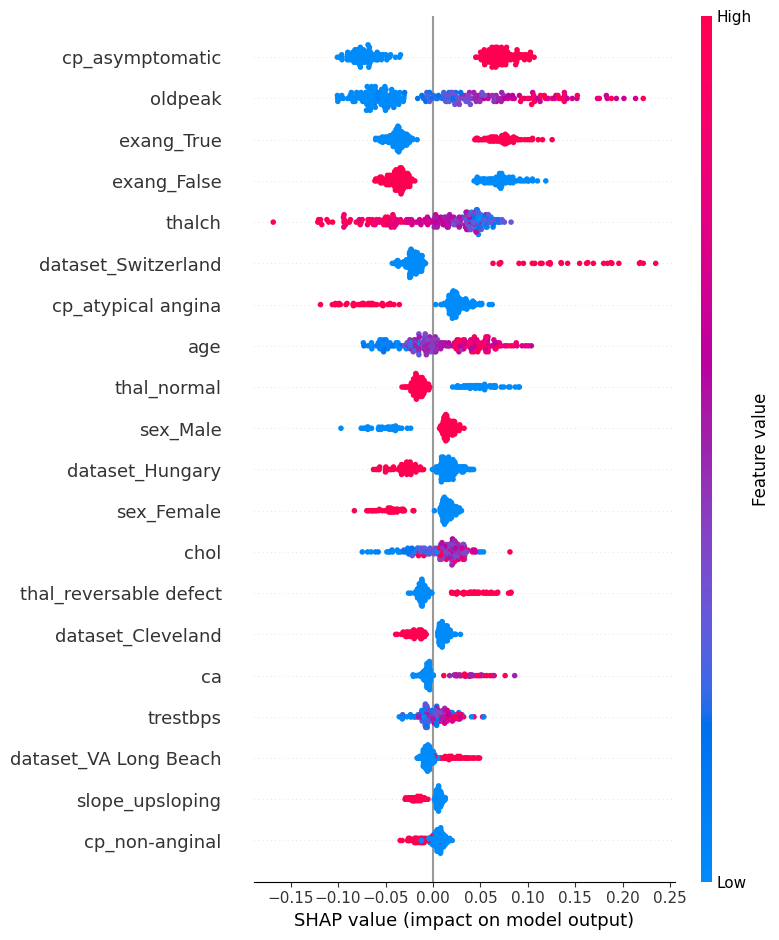

In [11]:
explainer = shap.TreeExplainer(clf.named_steps["model"])
shap_values = explainer.shap_values(X_test_t)

print(shap_values.shape)
print(shap_values[:, :][0][:5])
positive_class = 1
shap_pos = shap_values[:, :, positive_class]

shap.summary_plot(shap_pos, X_test_t,
                  feature_names=feature_names, show=True)

### 7.2 Global explanation — feature importance (bar)


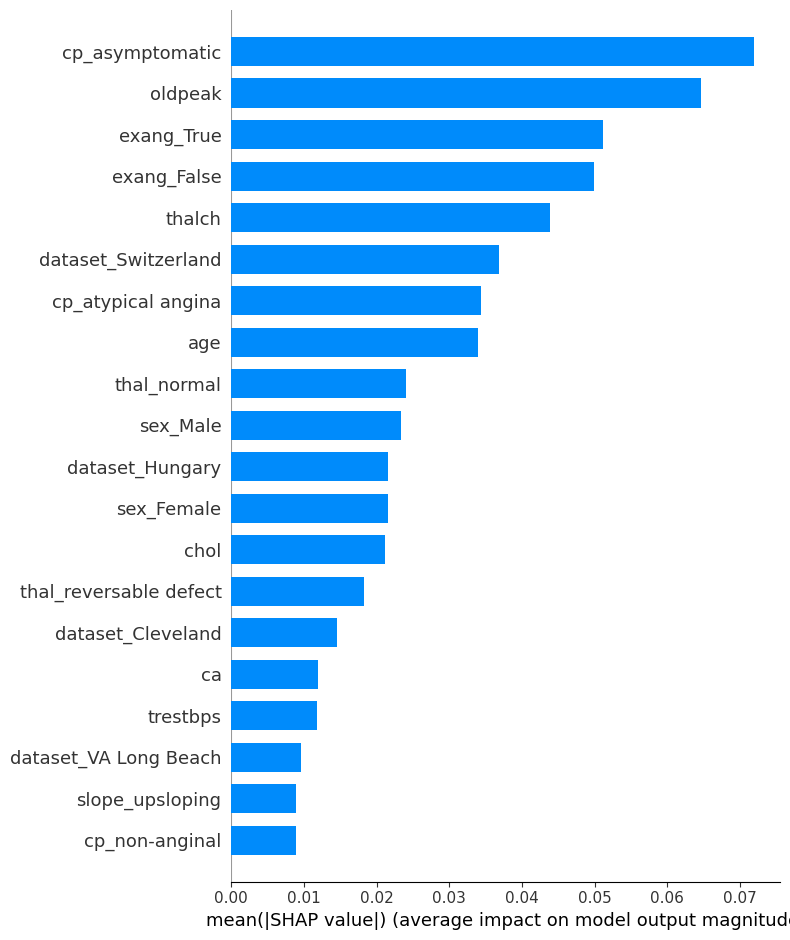

In [12]:
shap.summary_plot(shap_pos, X_test_t, feature_names=feature_names, plot_type="bar", show=True)


### 7.3 Dependence plot — how one feature affects prediction

Pick one feature (often a top feature from the bar plot) and visualize its effect.


Feature: age


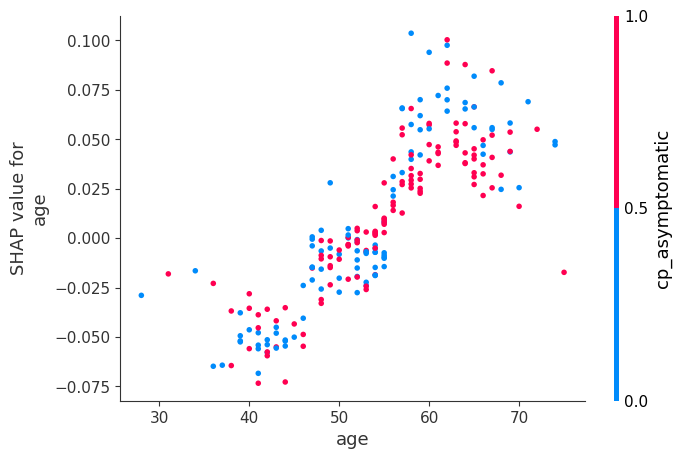

In [13]:
# Choose a feature to inspect (edit this if you want)
feature_to_plot = feature_names[0]  
print("Feature:", feature_to_plot)

shap.dependence_plot(
    feature_to_plot,
    shap_pos,
    X_test_t,
    feature_names=feature_names,
    show=True
)


## 8) Local explanation — why this case got this prediction

We will explain two cases:
- A **high-risk** case (highest predicted probability)
- A **low-risk** case (lowest predicted probability)

A SHAP waterfall plot shows, for one specific case, how each feature pushes the model’s prediction away from the baseline


In [14]:
# Get predicted probabilities for each test case
test_probs = clf.predict_proba(X_test)[:, 1]

high_idx = int(np.argmax(test_probs))
low_idx  = int(np.argmin(test_probs))

print("High-risk predicted probability:", test_probs[high_idx])
print("Low-risk predicted probability :", test_probs[low_idx])

X_test_t = clf.named_steps["preprocess"].transform(X_test)

X_test_model_input = pd.DataFrame(
    X_test_t, columns=feature_names, index=X_test.index)

print("\nHIGH-risk case (model input features):")
display(X_test_model_input.loc[[X_test.index[high_idx]]])

print("\nLOW-risk case (model input features):")
display(X_test_model_input.loc[[X_test.index[low_idx]]])

High-risk predicted probability: 0.9925
Low-risk predicted probability : 0.005

HIGH-risk case (model input features):


,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,restecg_normal,restecg_st-t abnormality,exang_False,exang_True,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
709,66.0,150.0,238.0,108.0,2.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0



LOW-risk case (model input features):


,age,trestbps,chol,thalch,oldpeak,ca,sex_Female,sex_Male,dataset_Cleveland,dataset_Hungary,...,restecg_normal,restecg_st-t abnormality,exang_False,exang_True,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
344,40.0,140.0,289.0,172.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


[0.50240573 0.49759427]
Waterfall — HIGH risk


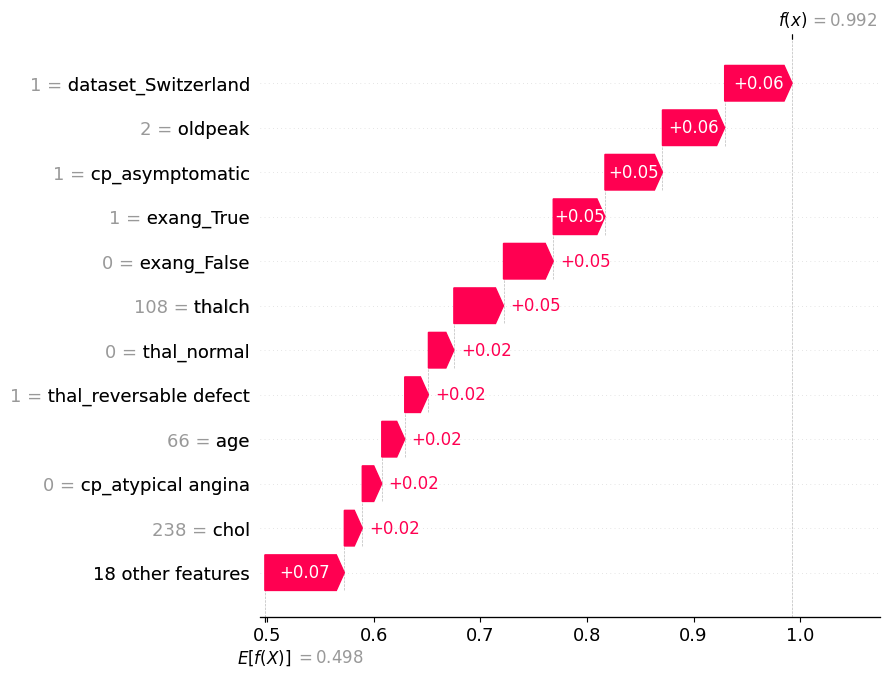


Waterfall — LOW risk


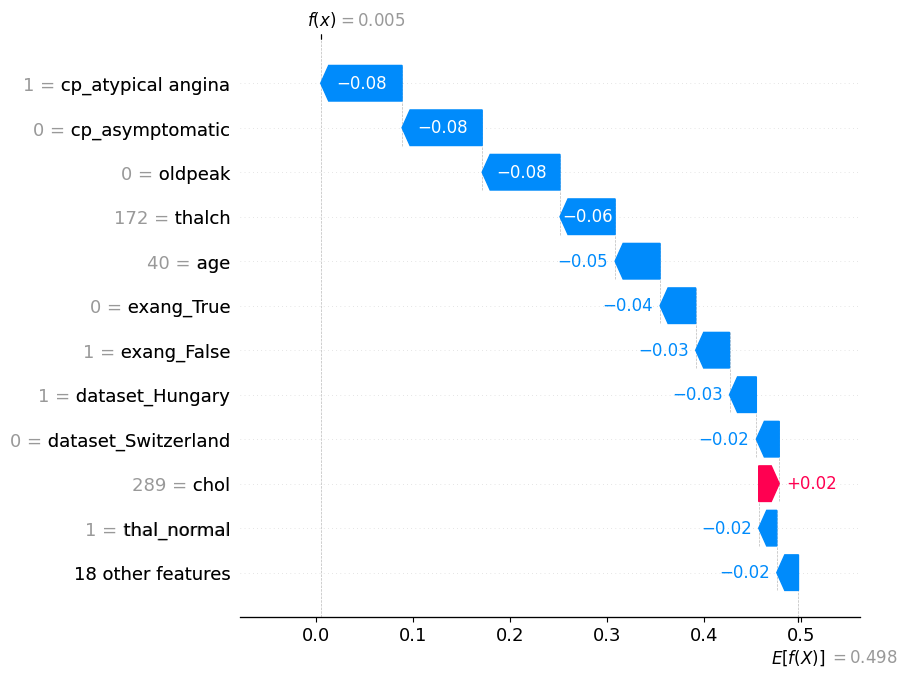

In [15]:
# Waterfall plots (local explanations)
# SHAP "expected_value" is the baseline model output; feature contributions push it up/down.

base = explainer.expected_value
print(base)
base_pos = base[1]

# High-risk case
exp_high = shap.Explanation(
    values=shap_pos[high_idx],
    base_values=base_pos,
    data=X_test_t[high_idx],
    feature_names=feature_names
)

# Low-risk case
exp_low = shap.Explanation(
    values=shap_pos[low_idx],
    base_values=base_pos,
    data=X_test_t[low_idx],
    feature_names=feature_names
)

print("Waterfall — HIGH risk")
shap.plots.waterfall(exp_high, max_display=12)

print("\nWaterfall — LOW risk")
shap.plots.waterfall(exp_low, max_display=12)
